# Desafio 5 - Maratona Behind the Code 2021

## Bibliotecas

In [1]:
import os
import sys
from datetime import timedelta
from pathlib import Path
from timeit import default_timer as timer
from warnings import simplefilter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import HTML, display
from sklearn import set_config
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.exceptions import ConvergenceWarning, UndefinedMetricWarning
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, f1_score, make_scorer,
                             plot_confusion_matrix, precision_score,
                             recall_score)
from sklearn.model_selection import (GridSearchCV, RandomizedSearchCV,
                                     train_test_split)
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (FunctionTransformer, MinMaxScaler,
                                   OneHotEncoder, RobustScaler, StandardScaler)
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier

## Configurações

In [2]:
seed = 0
data_path = Path("../desafio/assets/data/")
source_url = "https://github.com/maratonadev/desafio-5-2021/raw/main/assets/data/"
set_config(display="diagram")

# See https://stackoverflow.com/a/55595680/2062663
if not sys.warnoptions:
    simplefilter("ignore", category=ConvergenceWarning)
    simplefilter("ignore", category=UndefinedMetricWarning)
    os.environ["PYTHONWARNINGS"] = "ignore" # Also affect subprocesses

## Dados

### Download

In [3]:
!mkdir -p {data_path}
!wget -q -N -P {data_path} {source_url}"dataset.csv"
!wget -q -N -P {data_path} {source_url}"ANSWERS.csv"
!ls {data_path}

ANSWERS.csv  dataset.csv


### Carregamento

In [4]:
df_all = pd.read_csv(data_path / "dataset.csv")
answers = pd.read_csv(data_path / "ANSWERS.csv")

assert list(answers.columns) == list(df_all.columns)
all_cols = list(df_all.columns)
print(all_cols)

['ID', 'GENDER', 'SENIORCITIZEN', 'PARTNER', 'DEPENDENTS', 'TENURE', 'PHONESERVICE', 'MULTIPLELINES', 'INTERNETSERVICE', 'ONLINESECURITY', 'ONLINEBACKUP', 'DEVICEPROTECTION', 'TECHSUPPORT', 'STREAMINGTV', 'STREAMINGMOVIES', 'CONTRACT', 'PAPERLESSBILLING', 'PAYMENTMETHOD', 'MONTHLYCHARGES', 'TOTALCHARGES', 'CHURN']


### Informações gerais

In [5]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4548 entries, 0 to 4547
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                4548 non-null   int64  
 1   GENDER            4520 non-null   object 
 2   SENIORCITIZEN     4523 non-null   float64
 3   PARTNER           4524 non-null   object 
 4   DEPENDENTS        4526 non-null   object 
 5   TENURE            4533 non-null   float64
 6   PHONESERVICE      4520 non-null   object 
 7   MULTIPLELINES     4523 non-null   object 
 8   INTERNETSERVICE   4524 non-null   object 
 9   ONLINESECURITY    4518 non-null   object 
 10  ONLINEBACKUP      4518 non-null   object 
 11  DEVICEPROTECTION  4524 non-null   object 
 12  TECHSUPPORT       4530 non-null   object 
 13  STREAMINGTV       4523 non-null   object 
 14  STREAMINGMOVIES   4523 non-null   object 
 15  CONTRACT          4525 non-null   object 
 16  PAPERLESSBILLING  4517 non-null   object 


- A maioria das variáveis (colunas) parece não ser numérica e precisará ser tratada antes do uso em modelos de machine learning.
- Com exceção da variável que identifica cada cliente (`ID`) e da variável de destino (`CHURN`), todas têm dados faltantes (nulos).

### Divisão dos dados entre treino e teste

Antes de inspecionar os dados, serão reservados alguns exemplos para teste, que não serão vistos durante a análise ou modelagem dos dados:

In [6]:
test_size = 4200
target = "CHURN"
df_train, df_test = train_test_split(
    df_all, test_size=test_size, random_state=seed, stratify=df_all[[target]]
)
print(f"Dimensões dos dados de treino: {df_train.shape}")
print(f"Dimensões dos dados de teste: {df_test.shape}")

Dimensões dos dados de treino: (348, 21)
Dimensões dos dados de teste: (4200, 21)


### Variável destino

A variável destino para este desafio é `CHURN`, que indica se o cliente foi perdido ou não. Vamos dar uma olhada em como está a distribuição dessa variável:

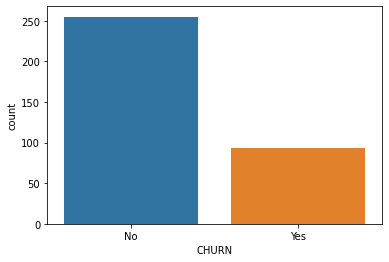

In [7]:
churn_plot = sns.countplot(
    data=df_train, x=target, order=df_train[target].value_counts().index
)
plt.show()

In [8]:
df_train[target].value_counts(normalize=True).rename("Proporção").to_frame()

,Proporção
No,0.732759
Yes,0.267241


- A maioria dos clientes (cerca de 73%) não foi perdido

### Dados de exemplo

In [9]:
with pd.option_context("display.max_columns", None):
    display(df_train.sample(10, random_state=seed))

,ID,GENDER,SENIORCITIZEN,PARTNER,DEPENDENTS,TENURE,PHONESERVICE,MULTIPLELINES,INTERNETSERVICE,ONLINESECURITY,ONLINEBACKUP,DEVICEPROTECTION,TECHSUPPORT,STREAMINGTV,STREAMINGMOVIES,CONTRACT,PAPERLESSBILLING,PAYMENTMETHOD,MONTHLYCHARGES,TOTALCHARGES,CHURN
2195,2255,Male,1.0,Yes,No,52.0,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,Bank transfer (automatic),311.34,5582.64,No
2342,9814,Male,0.0,No,No,1.0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Electronic check,33.37,33.37,Yes
2627,6071,Female,0.0,Yes,Yes,21.0,Yes,No,DSL,No,Yes,No,No,Yes,No,One year,Yes,Credit card (automatic),83.33,1239.93,No
1979,1570,Female,0.0,Yes,No,2.0,No,No phone service,DSL,No,No,No,No,No,Yes,Month-to-month,Yes,Electronic check,7.00,40.65,Yes
2438,7728,Female,1.0,No,No,7.0,Yes,No,Fiber optic,No,No,No,No,Yes,Yes,Month-to-month,Yes,Electronic check,76.83,562.03,No
2205,4859,Male,0.0,Yes,Yes,39.0,Yes,No,Fiber optic,No,Yes,No,No,Yes,No,Month-to-month,Yes,Mailed check,78.15,3257.85,Yes
275,4751,Male,0.0,Yes,No,67.0,Yes,No,DSL,Yes,Yes,No,Yes,No,Yes,NaN,Yes,Credit card (automatic),71.04,4673.49,No
2217,6414,Female,0.0,Yes,Yes,6.0,Yes,No,DSL,No,No,No,No,No,No,Month-to-month,No,Mailed check,88.02,327.72,No
2742,8456,Male,0.0,Yes,Yes,47.0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check,42.64,974.14,No
1392,2770,Male,1.0,No,No,9.0,Yes,Yes,Fiber optic,No,No,No,No,No,Yes,Month-to-month,Yes,Electronic check,147.24,853.54,Yes


### Valores distintos por variável

In [10]:
df_train.nunique().rename("Nº de valores").to_frame()

,Nº de valores
ID,348
GENDER,2
SENIORCITIZEN,2
PARTNER,2
DEPENDENTS,2
TENURE,72
PHONESERVICE,2
MULTIPLELINES,3
INTERNETSERVICE,3
ONLINESECURITY,3


Observações:
- As colunas `ID`, `MONTHLYCHARGES`, `TENURE` e `TOTALCHARGES` assumem um grande número de valores distintos, e possivelmente são contínuas
- As demais colunas têm poucos valores distintos, e podemos assumir que são categóricas

### Variáveis categóricas

Já que teremos que lidar tanto com variáveis categóricas quanto numéricas, e cada tipo de variável precisa de tratamentos específicos antes de serem usadas por modelos de _machine learning_, processaremos cada tipo por `Pipeline` específica do `scikit-learn`. Aqui, será construída uma versão preliminar da _pipeline_ que lidará com os dados categóricos, apenas para facilitar a visualização dos dados. Posteriormente ela será aperfeiçoada para uso nos modelos.

In [11]:
categorical_features = [
    "GENDER",
    "SENIORCITIZEN",
    "PARTNER",
    "DEPENDENTS",
    "PHONESERVICE",
    "MULTIPLELINES",
    "INTERNETSERVICE",
    "ONLINESECURITY",
    "ONLINEBACKUP",
    "DEVICEPROTECTION",
    "TECHSUPPORT",
    "STREAMINGTV",
    "STREAMINGMOVIES",
    "CONTRACT",
    "PAPERLESSBILLING",
    "PAYMENTMETHOD",
    # 'CHURN',  # This is the binary target, not a feature
]


def cat_mapper(df):
    return df.astype("category")


categorical_transformer = Pipeline(
    steps=[
        ("to_categorical", FunctionTransformer(cat_mapper)),
    ]
)

df_train_cat = categorical_transformer.fit_transform(
    df_train[categorical_features + [target]]
)

with pd.option_context("display.max_columns", None):
    display(df_train_cat.describe())

,GENDER,SENIORCITIZEN,PARTNER,DEPENDENTS,PHONESERVICE,MULTIPLELINES,INTERNETSERVICE,ONLINESECURITY,ONLINEBACKUP,DEVICEPROTECTION,TECHSUPPORT,STREAMINGTV,STREAMINGMOVIES,CONTRACT,PAPERLESSBILLING,PAYMENTMETHOD,CHURN
count,347,344.0,344,345,347,346,347,344,348,346,346,348,345,345,347,348,348
unique,2,2.0,2,2,2,3,3,3,3,3,3,3,3,3,2,4,2
top,Male,0.0,No,No,Yes,No,Fiber optic,No,No,No,No,No,Yes,Month-to-month,Yes,Electronic check,No
freq,192,271.0,181,263,315,178,151,155,155,147,175,133,140,192,200,110,255


In [12]:
def display_value_counts(df):
    for col in df:
        print(f"{col}:")
        display(
            df[col]
            .value_counts()
            .reset_index()
            .sort_values([col, "index"], ascending=False)
            .rename(columns={col: "Quantidade", "index": "Valor"})
            .set_index("Valor")
            .T
        )

Estes são os valores que as variáveis categóricas assumem:

In [13]:
display_value_counts(df_train[categorical_features])

GENDER:


Valor,Male,Female
Quantidade,192,155


SENIORCITIZEN:


Valor,0.0,1.0
Quantidade,271,73


PARTNER:


Valor,No,Yes
Quantidade,181,163


DEPENDENTS:


Valor,No,Yes
Quantidade,263,82


PHONESERVICE:


Valor,Yes,No
Quantidade,315,32


MULTIPLELINES:


Valor,No,Yes,No phone service
Quantidade,178,137,31


INTERNETSERVICE:


Valor,Fiber optic,DSL,No
Quantidade,151,113,83


ONLINESECURITY:


Valor,No,Yes,No internet service
Quantidade,155,106,83


ONLINEBACKUP:


Valor,No,Yes,No internet service
Quantidade,155,110,83


DEVICEPROTECTION:


Valor,No,Yes,No internet service
Quantidade,147,117,82


TECHSUPPORT:


Valor,No,Yes,No internet service
Quantidade,175,88,83


STREAMINGTV:


Valor,No,Yes,No internet service
Quantidade,133,132,83


STREAMINGMOVIES:


Valor,Yes,No,No internet service
Quantidade,140,124,81


CONTRACT:


Valor,Month-to-month,One year,Two year
Quantidade,192,81,72


PAPERLESSBILLING:


Valor,Yes,No
Quantidade,200,147


PAYMENTMETHOD:


Valor,Electronic check,Mailed check,Bank transfer (automatic),Credit card (automatic)
Quantidade,110,95,77,66


Observações:
- Antes de serem utilizadas por um modelo, será conveniente converter essas variáveis em valores numéricos usando "One-Hot-Encoding".
- Como há valores faltantes para essas variáveis (vide [informações gerais](#Informações-gerais)), será importante imputar algum valor (por exemplo, o que for mais frequente em cada coluna)

### Variáveis numéricas

Por hora, apenas para visualizar estatísticas sobre os valores numéricos, valores textuais nessas colunas serão trocados por `NaN` usando um *transformer* personalizado:

In [14]:
numeric_features = [
    # 'ID',  # This is just an identifier, not a feature
    "MONTHLYCHARGES",
    "TENURE",
    "TOTALCHARGES",
]


def num_mapper(df):
    def col_mapper(col):
        return pd.to_numeric(col, errors="coerce")

    return df.apply(col_mapper)


numeric_transformer = Pipeline(
    steps=[
        ("to_numeric", FunctionTransformer(num_mapper)),
    ]
)

df_train_num = numeric_transformer.fit_transform(df_train[["ID"] + numeric_features])

df_train_clean = pd.concat([df_train_cat, df_train_num], axis=1)[
    df_train.columns
].copy()

with pd.option_context("display.max_columns", None):
    display(df_train_num.describe())

,ID,MONTHLYCHARGES,TENURE,TOTALCHARGES
count,348.000000,343.000000,348.000000,348.000000
mean,5703.732759,93.247551,30.905172,2193.656983
std,2667.166073,75.155158,24.044859,2239.585642
min,1009.000000,0.260000,1.000000,0.360000
25%,3328.500000,32.505000,7.000000,364.325000
50%,5904.000000,69.350000,27.000000,1240.630000
75%,8084.750000,142.685000,52.250000,3536.375000
max,9997.000000,313.530000,72.000000,8051.960000


Estes são os valores que as variáveis numéricas assumem:

In [15]:
with pd.option_context("display.max_columns", 6):
    display_value_counts(df_train_num)

ID:


Valor,9997,9953,9948,...,1101,1089,1009
Quantidade,1,1,1,...,1,1,1


MONTHLYCHARGES:


Valor,60.89,17.11,313.53,...,1.53,0.36,0.26
Quantidade,2,2,1,...,1,1,1


TENURE:


Valor,1.0,72.0,2.0,...,48.0,44.0,19.0
Quantidade,30,15,13,...,1,1,1


TOTALCHARGES:


Valor,8051.96,8043.58,8011.91,...,12.92,8.29,0.36
Quantidade,1,1,1,...,1,1,1


### Correlações

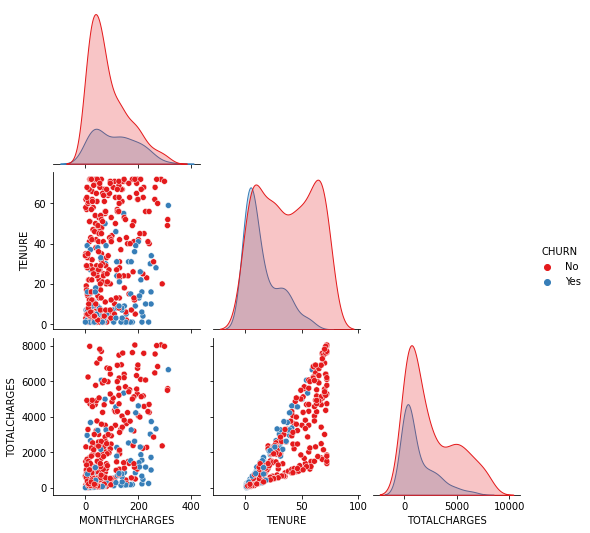

In [16]:
sns.pairplot(
    df_train_clean[numeric_features + [target]], hue=target, palette="Set1", corner=True
)
plt.show()

### Variáveis categóricas (gráficos)

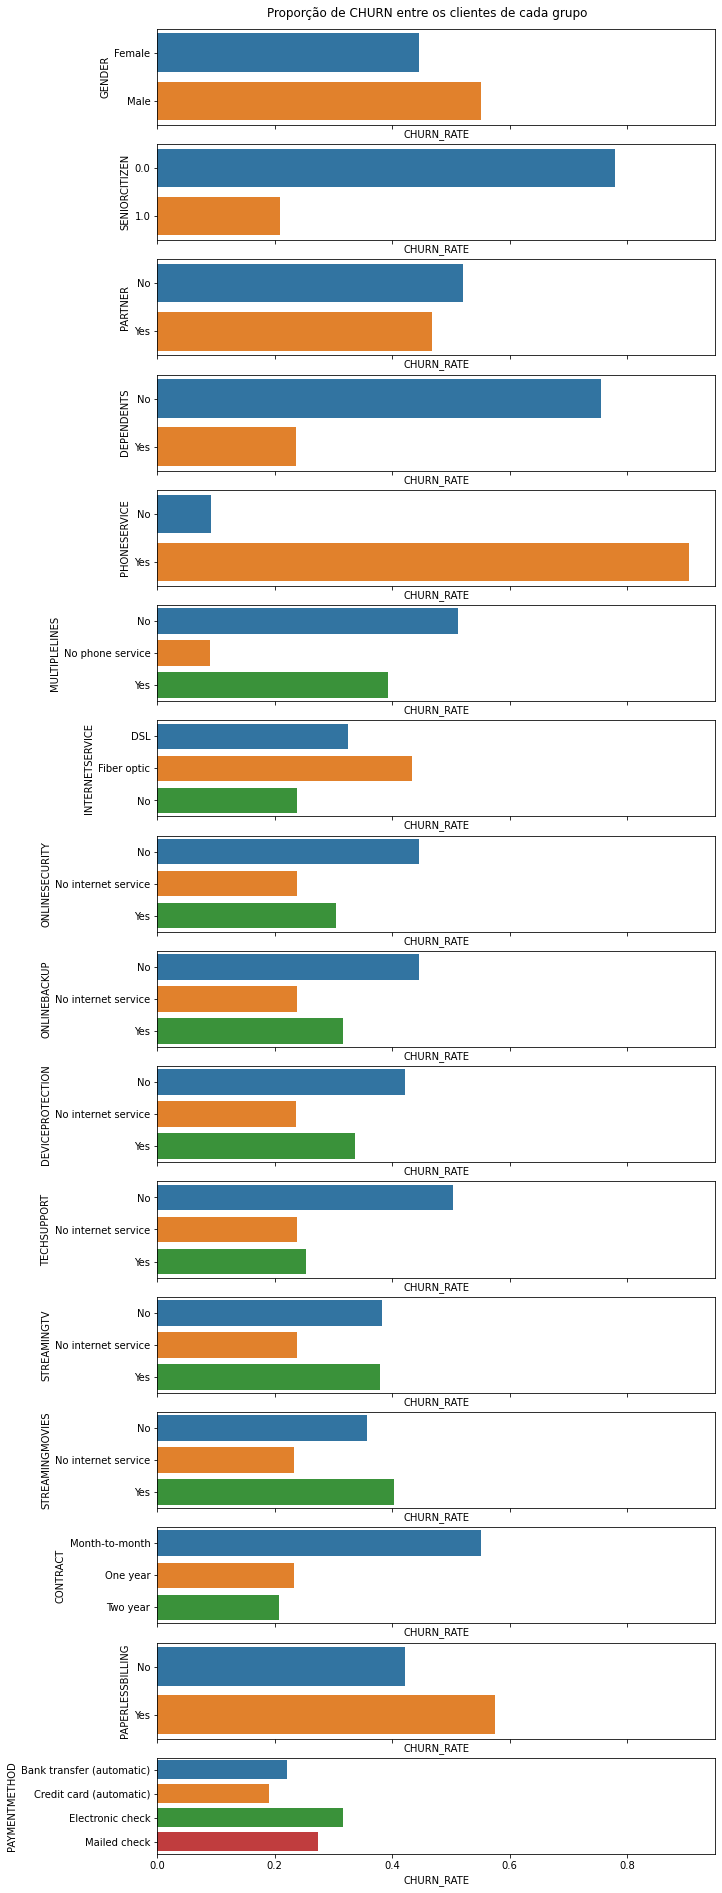

In [17]:
fig, axes = plt.subplots(nrows=len(categorical_features), sharex=True, figsize=(10, 30))
for i, col in enumerate(categorical_features):
    group_means = (
        (df_train_clean.groupby([col])[target].count() / len(df_train_clean))
        .rename(f"{target}_RATE")
        .sort_values(ascending=False)
        .to_frame()
    )
    sns.barplot(x=f"{target}_RATE", y=group_means.index, data=group_means, ax=axes[i])
    fig.subplots_adjust(top=0.97)
    fig.suptitle("Proporção de CHURN entre os clientes de cada grupo")

### Pré-processamento dos dados

Será criada uma _pipeline_ de pré-processamento com transformações específicas para cada tipo de variável:

In [18]:
categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore")),
    ]
)

numeric_transformer = Pipeline(
    steps=[
        ("to_numeric", FunctionTransformer(num_mapper)),
        ("imputer", SimpleImputer(strategy="constant", fill_value=0)),
        ("scaler", StandardScaler()),
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

# preprocessor.fit(df_train)
# onehot_features = list(preprocessor.named_transformers_["cat"]["onehot"].get_feature_names())
# df_train_preprocessed = pd.DataFrame(
#     preprocessor.transform(df_train),
#     columns=numeric_features + onehot_features,
#     index=df_train.index
# )

## Criação de um modelo

Nosso objetivo é obter um algoritmo de Machine Learning que identifique se um cliente será perdido ou não, e que tenha o maior score F1 possível. Para começar, vamos comparar uma simples árvore de decisão com um modelo fictício, que apenas chuta suas predições (sem levar em conta nenhum feature), para ter valores de referência ao buscar uma solução ótima em termos da métrica F1.

In [19]:
pipe = Pipeline(
    [("preprocessor", preprocessor), ("clf", DecisionTreeClassifier(random_state=seed))]
)
# display(pipe)

Abaixo, separamos os dados que queremos predizer dos dados que utilizamos como informações para a predição.

In [20]:
X_train = df_train[all_cols]
y_train = df_train[target]
X_test = df_test[all_cols]
y_test = df_test[target]
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(348, 21)
(348,)
(4200, 21)
(4200,)


In [21]:
scaler_grid = [
    StandardScaler(),
    MinMaxScaler(),
    RobustScaler(),
    # "passthrough",
]
preprocessor_grid1 = {
    "preprocessor__num__imputer__strategy": ["mean", "median", "most_frequent"],
    "preprocessor__num__scaler": scaler_grid,
}
preprocessor_grid2 = {
    "preprocessor__num__imputer__strategy": ["constant"],
    "preprocessor__num__imputer__fill_value": [-1, 0],
    "preprocessor__num__scaler": scaler_grid,
}
    
classifier_grid1 = {
        "clf": [SVC(max_iter=1000, random_state=seed)],
        'clf__C': np.logspace(-10, 10, num=200),
        'clf__gamma': np.logspace(-10, 10, num=200),
        'clf__kernel': ['linear', 'rbf', 'sigmoid'],
}
classifier_grid2 = {
        "clf": [SVC(max_iter=1000, random_state=seed)],
        'clf__C': np.logspace(-10, 10, num=200),
        'clf__gamma': np.logspace(-10, 10, num=200),
        'clf__kernel': ['poly'],
        'clf__degree': [2, 3, 4],
}
param_grid = [
    # {
    #     "clf": [GaussianNB()],
    #     "preprocessor__num__imputer__strategy": ["mean"],
    #     "preprocessor__num__scaler": ["passthrough"],
    # },
    # {
    #     "clf": [KNeighborsClassifier(n_neighbors=115, weights='distance')],
    #     "preprocessor__num__imputer__strategy": ["most_frequent"],
    #     "preprocessor__num__scaler": [StandardScaler()],
    # },
    # {
    #     "clf": [LinearSVC(C=231.0129700083158, loss='hinge', max_iter=10000, random_state=seed)],
    #     "preprocessor__num__imputer__strategy": ["constant"],
    #     "preprocessor__num__imputer__fill_value": [0],
    #     "preprocessor__num__scaler": [RobustScaler()],
    # },
    # {
    #     "clf": [
    #         MLPClassifier(
    #             activation='logistic',
    #             alpha=1e-09,
    #             hidden_layer_sizes=(39, 36),
    #             learning_rate_init=0.00031622776601683794,
    #             learning_rate="constant",
    #             max_iter=10000,
    #             random_state=seed
    #         )
    #     ],
    #     "preprocessor__num__imputer__strategy": ["mean"],
    #     "preprocessor__num__scaler": [StandardScaler()],
    # },
    # {
    #     "clf": [LogisticRegression(C=0.2848035868435802, max_iter=100000, penalty='l1', solver='liblinear', random_state=seed)],
    #     "preprocessor__num__imputer__strategy": ["most_frequent"],
    #     "preprocessor__num__scaler": [StandardScaler()],
    # },
    # {
    #     "clf": [
    #         DecisionTreeClassifier(
    #             criterion="entropy",
    #             max_depth=5,
    #             max_features=0.8,
    #             min_samples_leaf=90,
    #             min_samples_split=55,
    #             random_state=seed,
    #         )
    #     ],
    #     "preprocessor__num__imputer__strategy": ["mean"],
    #     "preprocessor__num__scaler": ["passthrough"],
    # },
    # {
    #     "clf": [
    #         RandomForestClassifier(
    #             max_depth=8,
    #             n_estimators=50,
    #             max_features=0.825,
    #             min_samples_split=5,
    #             min_samples_leaf=5,
    #             criterion="entropy",
    #             random_state=seed
    #         )
    #     ],
    #     "preprocessor__num__scaler": [MinMaxScaler()],
    #     "preprocessor__num__imputer__strategy": ["median"],
    # },
    {
        **classifier_grid1,
        **preprocessor_grid1,
    },
    {
        **classifier_grid1,
        **preprocessor_grid2,
    },
    {
        **classifier_grid2,
        **preprocessor_grid1,
    },
    {
        **classifier_grid2,
        **preprocessor_grid2,
    },
]

In [22]:
cv_num = 10
verbose = 1

f1_scorer = make_scorer(f1_score, pos_label="Yes")
accuracy_scorer = make_scorer(accuracy_score)
precision_scorer = make_scorer(precision_score, pos_label="Yes")
recall_scorer = make_scorer(recall_score, pos_label="Yes")
scoring = {
    "f1": f1_scorer,
    "accuracy": accuracy_scorer,
    "precision": precision_scorer,
    "recall": recall_scorer,
}
scoring_name = "f1"

cv_train_size = int(((cv_num - 1) / cv_num) * len(X_train))
cv_test_size = len(X_train) - cv_train_size

search_args = {
    "estimator": pipe,
    "cv": cv_num,
    "n_jobs": 3, #-1,
    "verbose": verbose,
    "scoring": scoring,
    "refit": scoring_name,
}

cv = RandomizedSearchCV(
    n_iter=50000, param_distributions=param_grid, random_state=seed, **search_args
)
# cv = GridSearchCV(param_grid=param_grid, **search_args)

start = timer()
cv.fit(X_train, y_train)
end = timer()
print(
    f"Tempo gasto para treinar o modelo {cv_num} vezes com cada combinação de parâmetros para encontrar a melhor: {timedelta(seconds=end-start)}"
)

Fitting 10 folds for each of 50000 candidates, totalling 500000 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done 101 tasks      | elapsed:    2.2s
[Parallel(n_jobs=3)]: Done 701 tasks      | elapsed:    9.3s
[Parallel(n_jobs=3)]: Done 1701 tasks      | elapsed:   22.7s
[Parallel(n_jobs=3)]: Done 3101 tasks      | elapsed:   44.0s
[Parallel(n_jobs=3)]: Done 4901 tasks      | elapsed:  1.2min
[Parallel(n_jobs=3)]: Done 7101 tasks      | elapsed:  1.8min
[Parallel(n_jobs=3)]: Done 9701 tasks      | elapsed:  2.4min
[Parallel(n_jobs=3)]: Done 12701 tasks      | elapsed:  3.1min
[Parallel(n_jobs=3)]: Done 16101 tasks      | elapsed:  3.9min
[Parallel(n_jobs=3)]: Done 19901 tasks      | elapsed:  4.9min
[Parallel(n_jobs=3)]: Done 24101 tasks      | elapsed:  5.9min
[Parallel(n_jobs=3)]: Done 28701 tasks      | elapsed:  7.2min
[Parallel(n_jobs=3)]: Done 33701 tasks      | elapsed:  8.7min
[Parallel(n_jobs=3)]: Done 39101 tasks      | elapsed: 10.0min
[Parallel(n_jobs=3)]: Done 44901 tasks      | elapse

Tempo gasto para treinar o modelo 10 vezes com cada combinação de parâmetros para encontrar a melhor: 1:58:47.101500


In [23]:
display(HTML("<h4>Dados brutos da validação cruzada</h4>"))
print(
    f"Cada combinação de parâmetros foi utilizada em {cv_num} rodadas de treino com {cv_train_size} exemplos e teste com {cv_test_size}."
)

rank_col = f"rank_test_{scoring_name}"
cv_df = pd.DataFrame(cv.cv_results_).sort_values(rank_col).set_index(rank_col)

cols = [
    f"mean_test_{scoring_name}",
    "mean_test_accuracy",
    "mean_test_precision",
    "mean_test_recall",
    "mean_fit_time",
    "params",
]
with pd.option_context("display.max_colwidth", None):
    display(cv_df[cols].head(20))

Cada combinação de parâmetros foi utilizada em 10 rodadas de treino com 313 exemplos e teste com 35.


,mean_test_f1,mean_test_accuracy,mean_test_precision,mean_test_recall,mean_fit_time,params
rank_test_f1,,,,,,
1,0.670312,0.798655,0.607854,0.764444,0.026044,"{'preprocessor__num__scaler': RobustScaler(), 'preprocessor__num__imputer__strategy': 'mean', 'clf__kernel': 'rbf', 'clf__gamma': 5.05263106533568e-10, 'clf__C': 6080224.261649427, 'clf': SVC(C=6080224.261649427, gamma=5.05263106533568e-10, max_iter=1000, random_state=0)}"
2,0.660919,0.816555,0.663800,0.680000,0.026454,"{'preprocessor__num__scaler': MinMaxScaler(), 'preprocessor__num__imputer__strategy': 'constant', 'preprocessor__num__imputer__fill_value': 0, 'clf__kernel': 'rbf', 'clf__gamma': 1.3049019780144015e-07, 'clf__C': 988495904.6625586, 'clf': SVC(C=6080224.261649427, gamma=5.05263106533568e-10, max_iter=1000, random_state=0)}"
3,0.659472,0.781513,0.577973,0.786667,0.032201,"{'preprocessor__num__scaler': StandardScaler(), 'preprocessor__num__imputer__strategy': 'most_frequent', 'clf__kernel': 'rbf', 'clf__gamma': 2.5529080682395164e-09, 'clf__C': 10000000000.0, 'clf': SVC(C=6080224.261649427, gamma=5.05263106533568e-10, max_iter=1000, random_state=0)}"
4,0.655912,0.775630,0.557805,0.806667,0.023907,"{'preprocessor__num__scaler': MinMaxScaler(), 'preprocessor__num__imputer__strategy': 'constant', 'preprocessor__num__imputer__fill_value': -1, 'clf__kernel': 'rbf', 'clf__gamma': 1.289890261253308e-08, 'clf__C': 61509857.88580504, 'clf': SVC(C=6080224.261649427, gamma=5.05263106533568e-10, max_iter=1000, random_state=0)}"
5,0.655145,0.778571,0.570030,0.786667,0.027364,"{'preprocessor__num__scaler': MinMaxScaler(), 'preprocessor__num__imputer__strategy': 'constant', 'preprocessor__num__imputer__fill_value': -1, 'clf__kernel': 'rbf', 'clf__gamma': 1e-10, 'clf__C': 38720387.81812557, 'clf': SVC(C=6080224.261649427, gamma=5.05263106533568e-10, max_iter=1000, random_state=0)}"
6,0.654415,0.813025,0.659325,0.656667,0.029830,"{'preprocessor__num__scaler': StandardScaler(), 'preprocessor__num__imputer__strategy': 'most_frequent', 'clf__kernel': 'rbf', 'clf__gamma': 4.0088063288984644e-10, 'clf__C': 4824108.7041653935, 'clf': SVC(C=6080224.261649427, gamma=5.05263106533568e-10, max_iter=1000, random_state=0)}"
7,0.653652,0.769832,0.557094,0.807778,0.027246,"{'preprocessor__num__scaler': RobustScaler(), 'preprocessor__num__imputer__strategy': 'median', 'clf__kernel': 'rbf', 'clf__gamma': 4.0088063288984644e-10, 'clf__C': 9658832.241158709, 'clf': SVC(C=6080224.261649427, gamma=5.05263106533568e-10, max_iter=1000, random_state=0)}"
7,0.653652,0.769832,0.557094,0.807778,0.026062,"{'preprocessor__num__scaler': RobustScaler(), 'preprocessor__num__imputer__strategy': 'mean', 'clf__kernel': 'rbf', 'clf__gamma': 1.2603829296797273e-10, 'clf__C': 30721129.98861772, 'clf': SVC(C=6080224.261649427, gamma=5.05263106533568e-10, max_iter=1000, random_state=0)}"
9,0.652501,0.775630,0.570351,0.785556,0.027213,"{'preprocessor__num__scaler': StandardScaler(), 'preprocessor__num__imputer__strategy': 'constant', 'preprocessor__num__imputer__fill_value': 0, 'clf__kernel': 'rbf', 'clf__gamma': 2.5529080682395164e-09, 'clf__C': 77525974.88629496, 'clf': SVC(C=6080224.261649427, gamma=5.05263106533568e-10, max_iter=1000, random_state=0)}"


In [24]:
model = cv.best_estimator_

display(HTML(f"<h4>Maior média de {scoring_name}</h4>"))
display(
    HTML(
        f"""<ul>
<li>Maior média de {scoring_name}: {cv.best_score_:.5f} (desvio padrão: {cv.cv_results_["std_test_" + scoring_name][cv.best_index_]:.5f})</li>
<li>Parâmetros que maximizaram a média de {scoring_name}:<br/><code>{cv.best_params_}</code></li>
<li>Modelo com a maior média de {scoring_name}:</li>
</ul>"""
    )
)
# display(model)

In [25]:
y_pred = model.predict(X_test)
score = f1_score(y_test, y_pred, pos_label="Yes")
print(f"F1-score do modelo no conjunto de testes: {score:.5f}")

F1-score do modelo no conjunto de testes: 0.61315


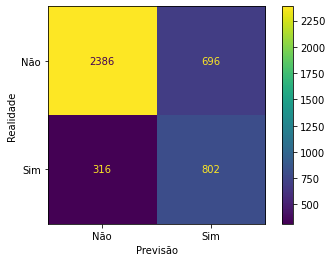

In [26]:
cmd = plot_confusion_matrix(model, X_test, y_test, display_labels=["Não", "Sim"])
cmd.ax_.set(xlabel="Previsão", ylabel="Realidade")
plt.show()

## Preenchimento do arquivo de respostas

In [27]:
answers["CHURN"] = model.predict(answers)
answers.to_csv("ANSWERS.csv", index=False)

with pd.option_context("display.max_columns", 6):
    display(answers.sample(2, random_state=seed))

,ID,GENDER,SENIORCITIZEN,...,MONTHLYCHARGES,TOTALCHARGES,CHURN
1294,3100,Female,0,...,123.64,972.34,Yes
406,4362,Female,1,...,7.00,7.0,Yes


In [28]:
answers[target].value_counts(normalize=True).rename("Proporção").to_frame()

,Proporção
No,0.672961
Yes,0.327039


In [29]:
!rm -rf código.zip
!zip -q código.zip notebook.ipynb
!ls código.zip

código.zip
